<a href="https://colab.research.google.com/github/cl6530/DL_final_project/blob/trading_env/training_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/trading_env/env.py
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/trading_env/utils.py

--2023-05-02 22:05:55--  https://raw.githubusercontent.com/cl6530/DL_final_project/trading_env/env.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2772 (2.7K) [text/plain]
Saving to: ‘env.py’

env.py              100%[===================>]   2.71K  --.-KB/s    in 0s      

2023-05-02 22:05:55 (31.2 MB/s) - ‘env.py’ saved [2772/2772]

--2023-05-02 22:05:55--  https://raw.githubusercontent.com/cl6530/DL_final_project/trading_env/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3790 (3.7K) [text/plain]
Saving to: ‘utils.py

In [23]:
from env import StockTradingEnv
from utils import select_action,Transition,ReplayMemory, optimize_model,get_data
from google.colab import drive
import torch
import torch.nn as nn
import random
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Get Data

In [3]:
drive.mount('/content/drive')
path = r'/content/drive/My Drive/Colab Notebooks/dataset'
data = get_data(drive_path = path)

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive
['/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2021.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2022.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2019.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2017.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2020.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2015.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2014.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2013.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2016.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2012.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2023.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2011.csv', '/content/drive/My Drive/Colab Notebooks/dataset/

# Models

In [19]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


EPS = 1
N_EXPLORATION = 20
TAU = 0.005
LR = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
policy_net = DQN(2, 3).to(device)
target_net = DQN(2, 3).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Train

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


episode:  0


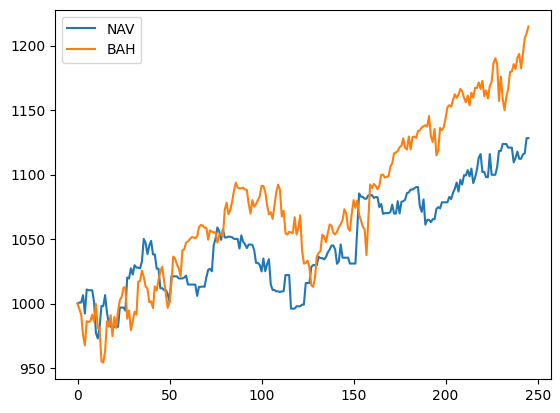

episode:  10


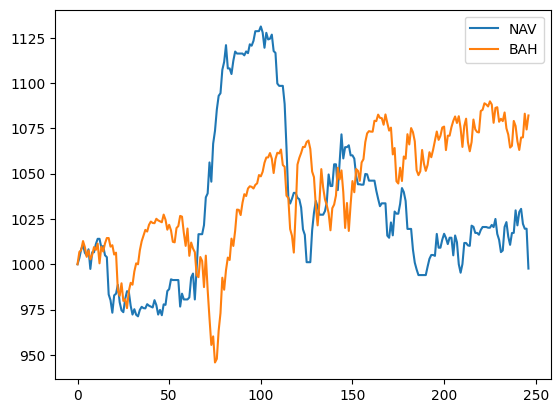

episode:  20


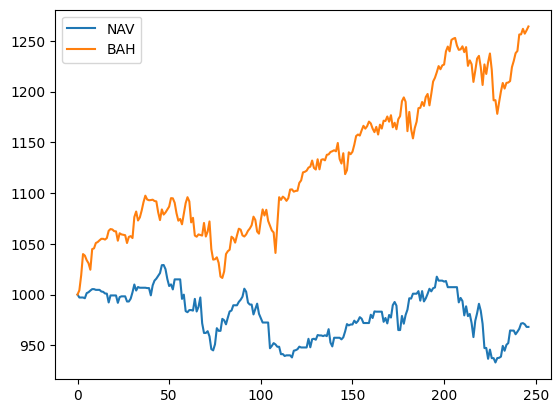

episode:  30


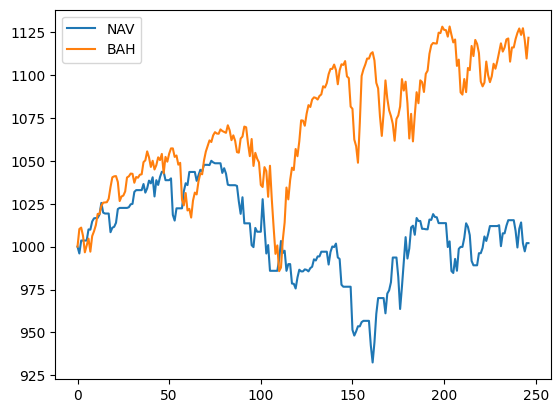

episode:  40


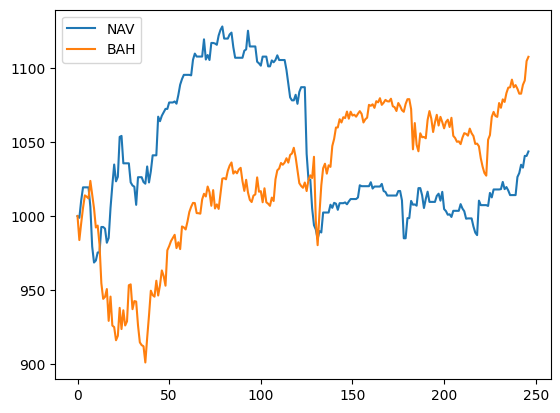

episode:  50


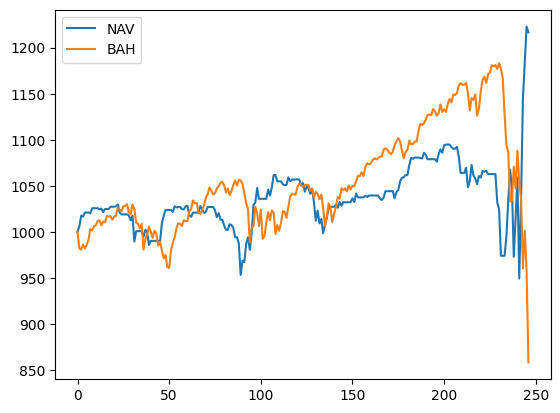

episode:  60


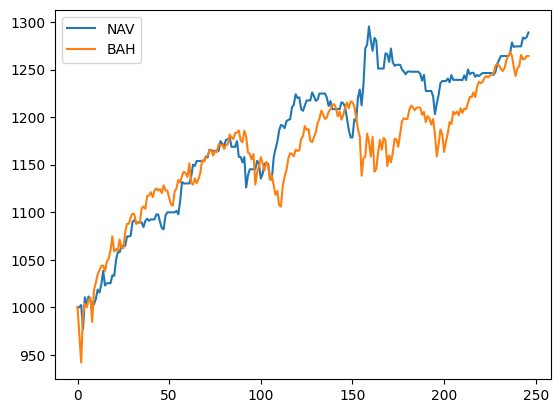

episode:  70


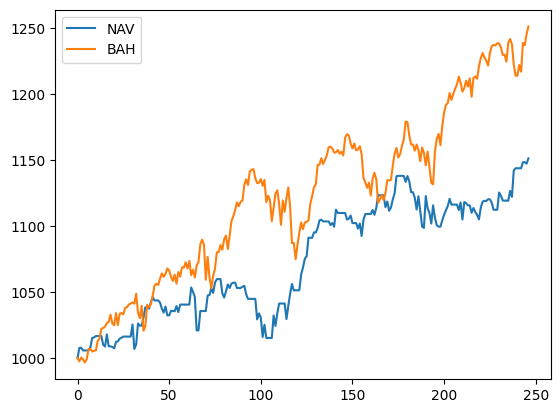

episode:  80


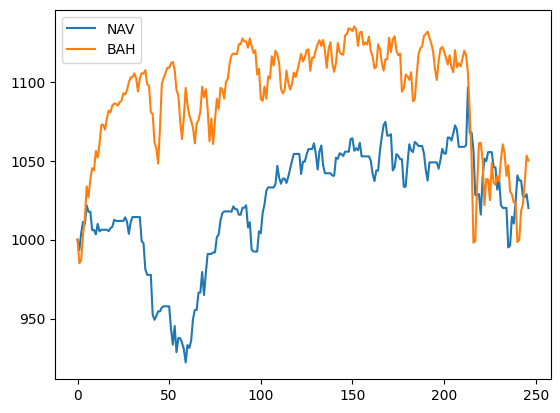

episode:  90


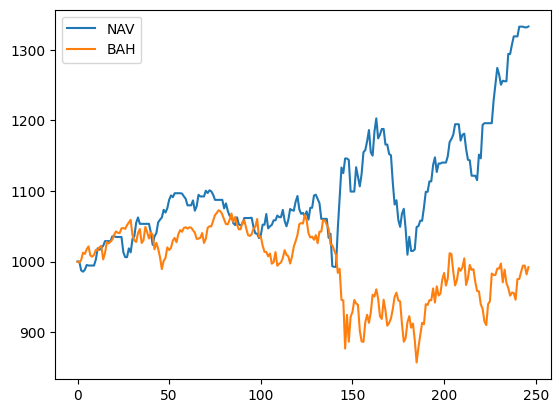

In [27]:
memory = ReplayMemory(100000)

if torch.cuda.is_available():
    num_episodes = 100
else:
    num_episodes = 50

for i_episode in range(num_episodes):

    # get 252 returns
    start = random.randint(0,len(data)-252)
    stock_returns = data.values[start:start + 252]

    #creat an env
    env = StockTradingEnv(stock_returns)
    done = False
    steps_done = 0

    NAV = [1000]
    BAH = [1000]

    while not done:
      
      #linear epsilon decay in the first n_exploration episodes, then exploit
      EPS = max(0,EPS-1/(252*N_EXPLORATION))
      state = env.current_state

      #get action
      action = select_action(state,EPS,env.action_space,policy_net,device)

      #step
      state, action,reward,next_state, done = env.step(action.item())

      #store in replay
      memory.push(torch.tensor(state.astype(np.float32),device=device), torch.tensor([action],device=device), torch.tensor(next_state.astype(np.float32),device=device), torch.tensor(reward,device=device))

      #optimize
      if len(memory) < 2:
          continue
      
      optimize_model(memory,optimizer,policy_net,target_net,device)

      # FIXME: Current Verision using soft update, the paper uses hard updates every 100 steps 
      target_net_state_dict = target_net.state_dict()
      policy_net_state_dict = policy_net.state_dict()
      for key in policy_net_state_dict:
          target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
      target_net.load_state_dict(target_net_state_dict)

      #append the reward
      NAV.append(NAV[-1]*(1+reward))
      BAH.append(BAH[-1]*(1+stock_returns[steps_done]))
      steps_done += 1
    if i_episode%10 == 0:
      print("episode: ", i_episode)
      plt.plot(NAV, label = 'NAV')
      plt.plot(BAH, label = 'BAH')
      plt.legend()
      plt.show()
